In [4]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Step 2: Load the Dataset
# Load the provided CSV file (ensure it's in the same directory as the notebook)
data = pd.read_csv('SriLanka_Weather_Dataset.csv')
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
       time  weathercode  temperature_2m_mean  apparent_temperature_mean  \
0  1/1/2020           51                 26.5                       30.7   
1  1/2/2020           51                 27.0                       31.1   
2  1/3/2020            2                 27.3                       30.9   
3  1/4/2020            2                 27.2                       29.3   
4  1/5/2020            1                 25.8                       26.5   

   rain_sum  windspeed_10m_max  windgusts_10m_max  winddirection_10m_dominant  \
0       0.1               10.0               23.8                         316   
1       0.4                9.2               25.9                         252   
2       0.0               11.0               27.7                         348   
3       0.0               11.4               28.8                           9   
4       0.0               17.0               36.4                          15   

   et0_fao_evapotranspira

In [7]:
# Step 3: Preprocess the Data
# Convert 'time' to datetime format (handle mixed formats and errors)
data['time'] = pd.to_datetime(data['time'], format='mixed', errors='coerce')

# Drop rows where 'time' could not be parsed
data = data.dropna(subset=['time'])

# Create binary target variable: 1 if rain_sum > 0, else 0
data['rain'] = (data['rain_sum'] > 0).astype(int)

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Handle missing values (if any) by imputing with mean
data = data.fillna(data.mean(numeric_only=True))

# Add month as a feature to capture seasonality
data['month'] = data['time'].dt.month

# Select features (excluding weathercode to avoid data leakage)
features = ['temperature_2m_mean', 'windspeed_10m_max', 'winddirection_10m_dominant', 'et0_fao_evapotranspiration', 'month']
X = data[features]
y = data['rain']

# Transform wind direction (circular feature) into sine and cosine components
X['wind_dir_sin'] = np.sin(np.radians(X['winddirection_10m_dominant']))
X['wind_dir_cos'] = np.cos(np.radians(X['winddirection_10m_dominant']))

# Drop the original wind direction column
X = X.drop('winddirection_10m_dominant', axis=1)


Missing values in each column:
time                          0
weathercode                   0
temperature_2m_mean           0
apparent_temperature_mean     0
rain_sum                      0
windspeed_10m_max             0
windgusts_10m_max             0
winddirection_10m_dominant    0
et0_fao_evapotranspiration    0
rain                          0
dtype: int64


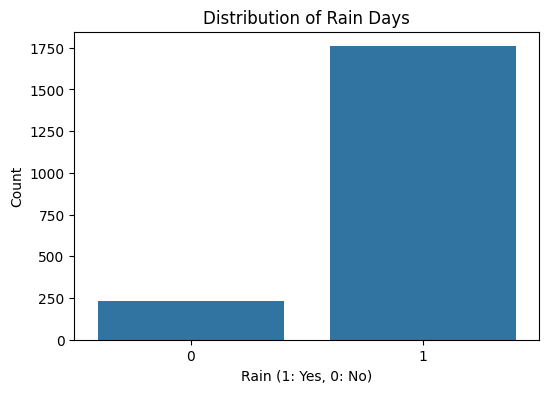

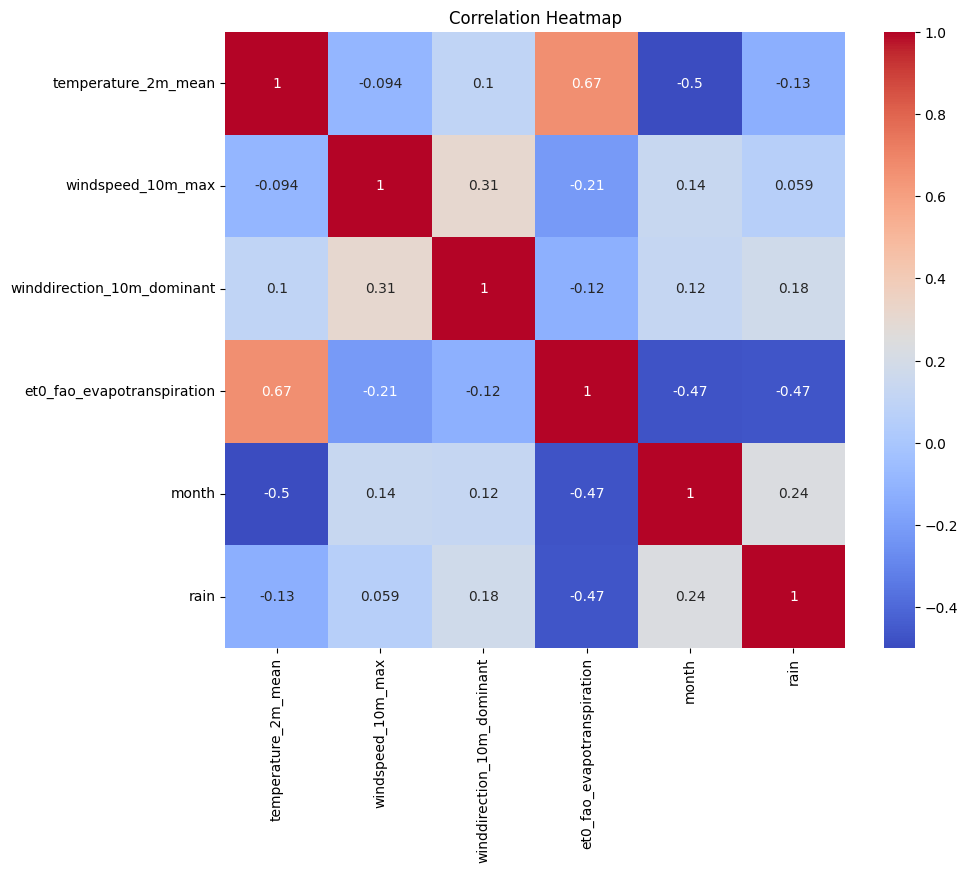

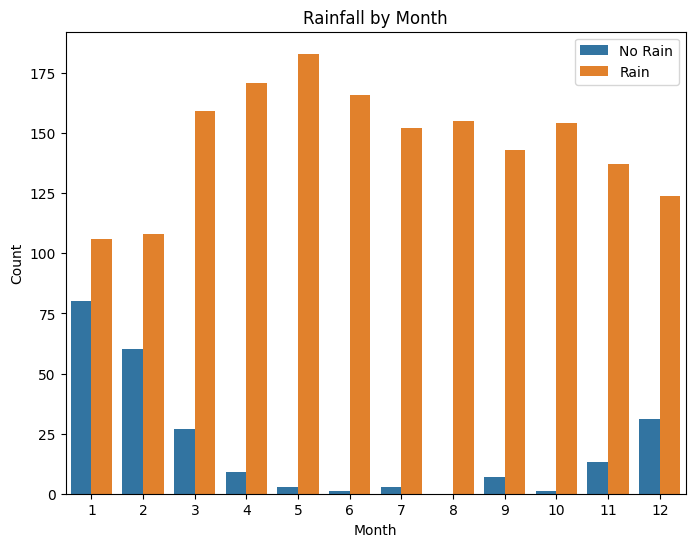

In [8]:
# Step 4: Exploratory Data Analysis (EDA)
# Distribution of rain days
plt.figure(figsize=(6, 4))
sns.countplot(x='rain', data=data)
plt.title('Distribution of Rain Days')
plt.xlabel('Rain (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data[features + ['rain']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Rainfall by month
plt.figure(figsize=(8, 6))
sns.countplot(x='month', hue='rain', data=data)
plt.title('Rainfall by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(['No Rain', 'Rain'])
plt.show()

In [9]:
# Step 5: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (1594, 6)
Testing set shape: (399, 6)



Random Forest Results:
Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.51      0.61        47
           1       0.94      0.98      0.96       352

    accuracy                           0.92       399
   macro avg       0.84      0.74      0.78       399
weighted avg       0.92      0.92      0.92       399

ROC-AUC: 0.91

Logistic Regression Results:
Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.83      0.57        47
           1       0.97      0.86      0.91       352

    accuracy                           0.85       399
   macro avg       0.71      0.84      0.74       399
weighted avg       0.91      0.85      0.87       399

ROC-AUC: 0.92


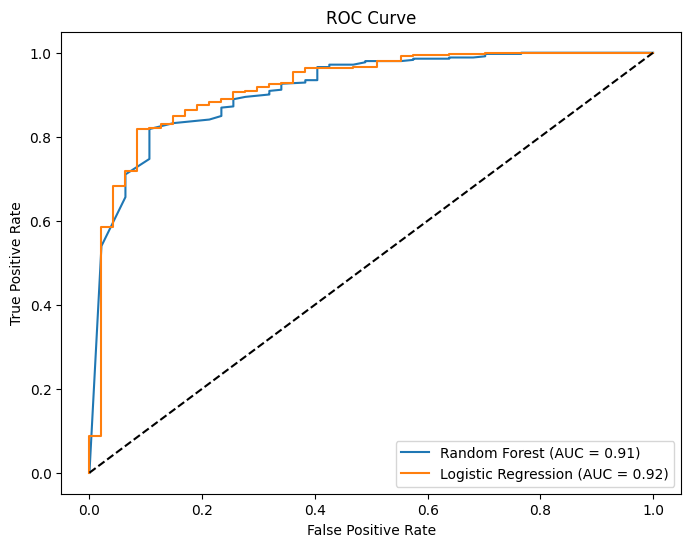

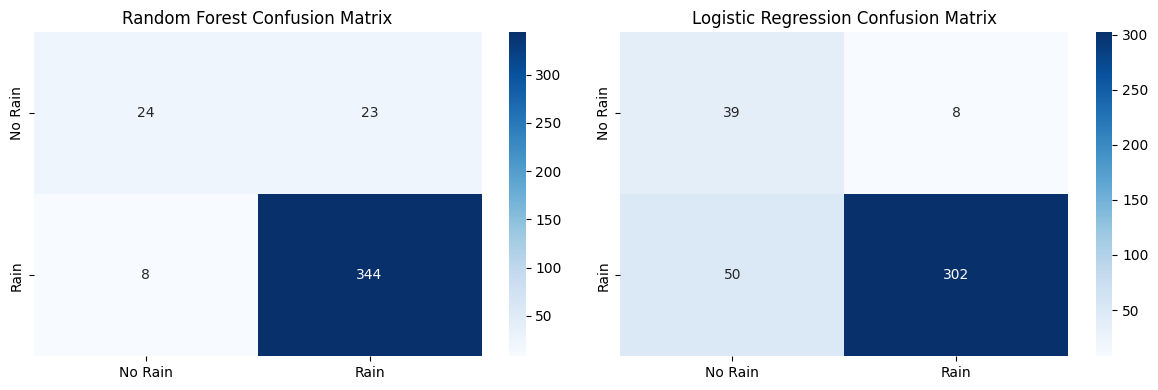

In [10]:
# Step 6: Train and Evaluate Models
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Logistic Regression (for comparison)
lr_model = LogisticRegression(random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Evaluate Random Forest
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, rf_pred))
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC: {rf_roc_auc:.2f}")

# Evaluate Logistic Regression
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, lr_pred))
lr_roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC: {lr_roc_auc:.2f}")

# Plot ROC Curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})', color='#1f77b4')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_roc_auc:.2f})', color='#ff7f0e')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot Confusion Matrices
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Random Forest Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.show()

In [11]:
# Step 7: Hyperparameter Tuning (Random Forest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)
print(f"Best F1 Score: {grid_search.best_score_:.2f}")



Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Score: 0.96


In [12]:
# Step 8: Final Model and Validation
best_rf = grid_search.best_estimator_
final_pred = best_rf.predict(X_test)
print("\nFinal Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, final_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, final_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.2f}")


Final Random Forest Results:
Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.55      0.59        47
           1       0.94      0.96      0.95       352

    accuracy                           0.91       399
   macro avg       0.79      0.76      0.77       399
weighted avg       0.91      0.91      0.91       399

ROC-AUC: 0.92



Feature Importance:
                      feature  importance
2  et0_fao_evapotranspiration    0.450332
3                       month    0.162795
5                wind_dir_cos    0.147281
1           windspeed_10m_max    0.085421
0         temperature_2m_mean    0.081137
4                wind_dir_sin    0.073035


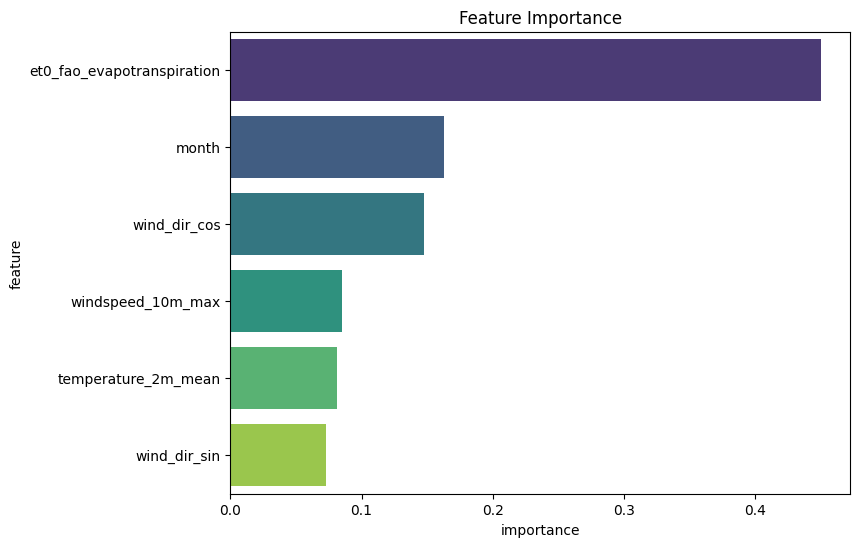

In [14]:
#Step 9: Feature Importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_rf.feature_importances_}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance')
plt.show()


In [15]:
# Step 10: Save the Model
import joblib
joblib.dump(best_rf, 'rainfall_model.pkl')
print("Model saved as rainfall_model.pkl")

Model saved as rainfall_model.pkl
